# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Basic Summary of the Data Set

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# The shape of an image
image_shape = X_train[0].shape

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Data Set

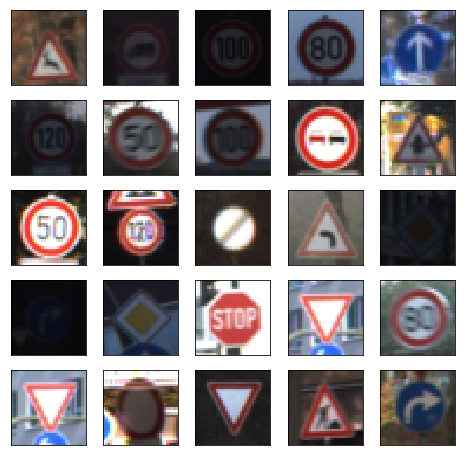

In [3]:
# Display a few random images from training set
import random
import matplotlib.pyplot as plt
%matplotlib inline

n_rows = 5
n_cols = 5
plt.figure(figsize=(8, 8))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train))
    image = X_train[index]
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

**The data set contains a lot of dark and bright images and needs to be normalized**

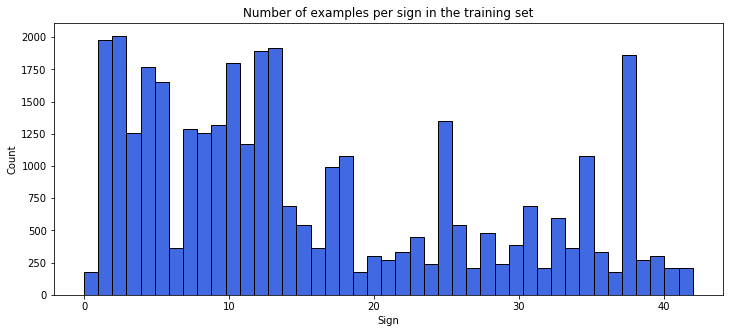

In [4]:
# Plot distribution of traffic signs in training set
plt.figure(figsize=(12, 5))
plt.hist(y_train, bins=n_classes, color='royalblue', edgecolor='black', linewidth=1)
plt.title('Number of examples per sign in the training set')
plt.xlabel('Sign')
plt.ylabel('Count')
plt.show()

In [5]:
# Display numbers and corresponding sing names
import pandas as pd

sign_names = pd.read_csv('signnames.csv')
print(sign_names.to_string(index=False))

ClassId                                           SignName
      0                               Speed limit (20km/h)
      1                               Speed limit (30km/h)
      2                               Speed limit (50km/h)
      3                               Speed limit (60km/h)
      4                               Speed limit (70km/h)
      5                               Speed limit (80km/h)
      6                        End of speed limit (80km/h)
      7                              Speed limit (100km/h)
      8                              Speed limit (120km/h)
      9                                         No passing
     10       No passing for vehicles over 3.5 metric tons
     11              Right-of-way at the next intersection
     12                                      Priority road
     13                                              Yield
     14                                               Stop
     15                                        No vehicl

In [6]:
# Print min/max label counts
import numpy as np

names, counts = np.unique(y_train, return_counts=True)
label_counts = pd.DataFrame(dict(zip(names, counts)), index=['Counts']).T
label_counts['Names'] = sign_names['SignName']
label_counts
print("Five min elements:\n")
print(label_counts.sort_values(['Counts']).head().to_string(index=False))
print("-"*45)
print("\nFive max elements:\n")
print(label_counts.sort_values(['Counts'], ascending=False).head().to_string(index=False))

Five min elements:

Counts                                Names
   180                 Speed limit (20km/h)
   180                  Go straight or left
   180          Dangerous curve to the left
   210  End of all speed and passing limits
   210                          Pedestrians
---------------------------------------------

Five max elements:

Counts                 Names
  2010  Speed limit (50km/h)
  1980  Speed limit (30km/h)
  1920                 Yield
  1890         Priority road
  1860            Keep right


**Above indicates that given data set is highly unbalanced**

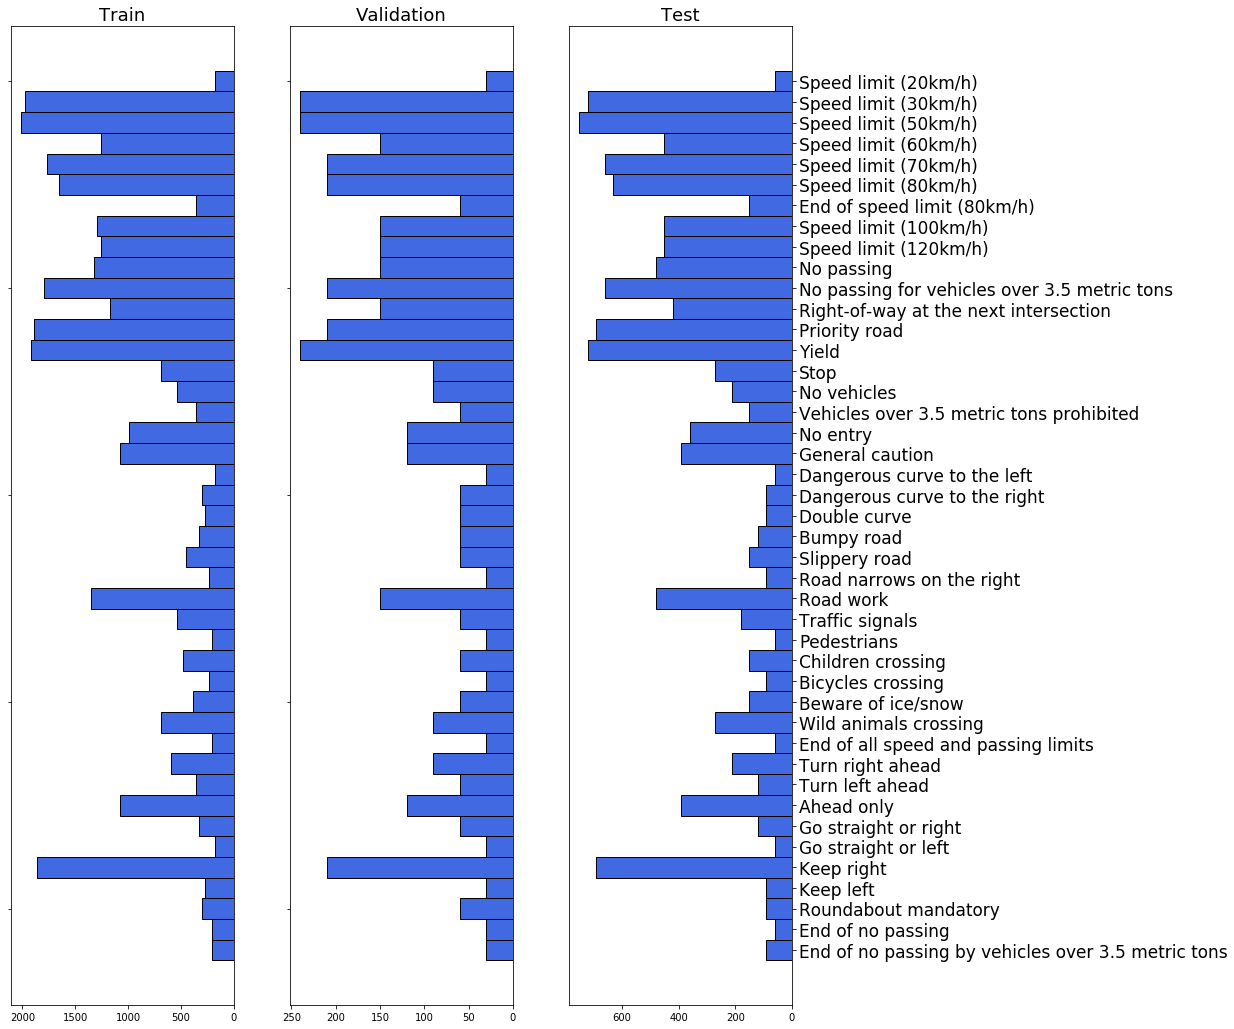

In [7]:
# Display distribution of labels across train, validation and test data
from matplotlib import gridspec

labels = sign_names['SignName'].tolist()
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows, ncols, wspace=0.25, hspace=0.1)
fig = plt.figure(figsize=(14,18))
ax1, ax2, ax3 = [plt.subplot(gs[:, i]) for i in range(ncols)]

ax1.set_title('Train', size=18)
ax2.set_title('Validation', size=18)
ax3.set_title('Test', size=18)

ax1.hist(y_train, bins=np.arange(n_classes+1)-0.5, color='royalblue',
         orientation='horizontal', edgecolor='black', linewidth=1)
ax1.set_yticklabels([])

ax2.hist(y_valid, bins=np.arange(n_classes+1)-0.5, color='royalblue',
         orientation='horizontal', edgecolor='black', linewidth=1)
ax2.set_yticklabels([])

ax3.hist(y_test, bins=np.arange(n_classes+1)-0.5, color='royalblue',
         orientation='horizontal', edgecolor='black', linewidth=1)
ax3.yaxis.tick_right()
ax3.get_yaxis().set_ticks([i for i in range(43)])
ax3.set_yticklabels(labels, size=17)

ax1.invert_yaxis()
ax1.invert_xaxis()

ax2.invert_yaxis()
ax2.invert_xaxis()

ax3.invert_yaxis()
ax3.invert_xaxis()

plt.show()

**The data distribution in train, validation and test sets is similar**

----

## Step 2: Design and Test a Model Architecture




### Pre-process the Data Set

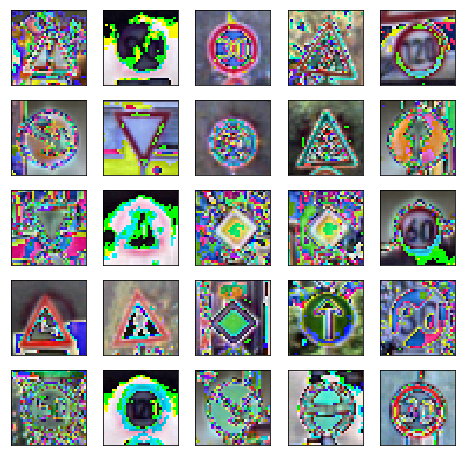

In [8]:
# Preprocess data: feature scaling and zero-centering 
import numpy as np

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train, axis=0)
X_valid_norm = (X_valid - np.mean(X_valid)) / np.std(X_valid, axis=0)
X_test_norm  = (X_test - np.mean(X_test)) / np.std(X_test, axis=0)

n_rows = 5
n_cols = 5
plt.figure(figsize=(8, 8))

for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    index = random.randint(0, len(X_train_norm))
    image = X_train_norm[index]
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

### Model Architecture

---
**Layer 1: Convolutional.** Input 32x32x3. Filter 5x5x64. Output 28x28x64.

- **Batch Normalization**

- **Activation.** ReLU.

- **Pooling.** Filter 2x2. Stride 2. Output 14x14x16.

- **Dropout** 0.65

**Layer 2: Convolutional.** Input 14x14x64. Filter 3x3x128. Output 12x12x128.

- **Batch Normalization**

- **Activation.** ReLU.

- **Pooling.** Filter 2x2. Stride 2. Output 6x6x128.

- **Dropout** 0.50

**Layer 3: Convolutional.** Input 6x6x128. Filter 3x3x256. Output 4x4x256.

- **Batch Normalization**

- **Activation.** ReLU.

- **Pooling.** Filter 2x2. Stride 2. Output 2x2x256.

- **Dropout** 0.50

**Flatten.** Flatten the output shape of the last convolutional layer such that it's 1D instead of 3D. 
Input 2x2x256. Output 1024.

**Layer 4: Fully Connected.** Input 1024. Output 512.

- **Batch Normalization**

- **Activation.** ReLU.

- **Dropout** 0.40

**Layer 5: Fully Connected.** Input 512. Output 512.

- **Batch Normalization**

- **Activation.** ReLU.

- **Dropout** 0.40

**Layer 6: Fully Connected (Logits).** Input 256. Output 43.
     
    
**Output: ** Return the result of the 3rd fully connected layer.

In [9]:
'''CNN 6 layers, He initialization, batch normalization, learning rate step decay, dropout. 
   CONV[5x5x64] -> CONV[3x3x128] -> CONV[3x3x256] -> FC[1024x512] -> FC[512x256] -> FC[256x43]'''

import tensorflow as tf
from sklearn.utils import shuffle

# Training parameters
epochs = 40
batch_size = 256
rate = 0.0012
dropout = [0.65, 0.5, 0.4]
step_decay = 0.5
decay_frequency = 5

# Tensorflow graph placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43)
# dropout parameters
keep_prob_conv1 = tf.placeholder(tf.float32, name='drop1')
keep_prob_conv2 = tf.placeholder(tf.float32, name='drop2')
keep_prob_fc = tf.placeholder(tf.float32, name='drop3')
# batch normalization parameter to set training/testing mode
phase = tf.placeholder(tf.bool, name='phase')

# CNN architecture
def FNet(x):      
    # Layer 1: Convolutional. Input = 32x32x3. Filter 5x5x64. Output = 28x28x64.  
    conv1_weights = tf.get_variable('W1', shape=[5, 5, 3, 64], 
                                    initializer=tf.contrib.layers.variance_scaling_initializer()) 
    conv1_biases = tf.get_variable('b1', shape=[64], initializer=tf.zeros_initializer())
    conv1 = tf.nn.conv2d(x, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, conv1_biases, name='conv1')
    # batch normalization
    conv1 = tf.contrib.layers.batch_norm(conv1, is_training=phase)
    # activation
    conv1 = tf.nn.relu(conv1)
    # max pooling
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') # Output = 14x14x64
    # dropout
    conv1 = tf.nn.dropout(conv1, keep_prob_conv1)
    print("Check shapes:")
    print("c1: ", conv1.get_shape())

    # Layer 2: Convolutional. Input = 14x14x64. Output = 12x12x128
    conv2_weights = tf.get_variable('W2', shape=[3, 3, 64, 128], 
                                    initializer=tf.contrib.layers.variance_scaling_initializer()) 
    conv2_biases = tf.get_variable('b2', shape=[128], initializer=tf.zeros_initializer())
    conv2 = tf.nn.conv2d(conv1, conv2_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, conv2_biases, name='conv2')
    # batch normalization
    conv2 = tf.contrib.layers.batch_norm(conv2, is_training=phase)
    # activation
    conv2 = tf.nn.relu(conv2)
    # max pooling
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') # Output = 6x6x128
    # dropout
    conv2 = tf.nn.dropout(conv2, keep_prob_conv2)
    print("c2: ", conv2.get_shape())
    
    # Layer 3: Convolutional. Input = 6x6x128. Output = 4x4x256
    conv3_weights = tf.get_variable('W3', shape=[3, 3, 128, 256], 
                                    initializer=tf.contrib.layers.variance_scaling_initializer()) 
    conv3_biases = tf.get_variable('b3', shape=[256], initializer=tf.zeros_initializer())
    conv3 = tf.nn.conv2d(conv2, conv3_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.bias_add(conv3, conv3_biases, name='conv3')
    # batch normalization
    conv3 = tf.contrib.layers.batch_norm(conv3, is_training=phase)
    # activation
    conv3 = tf.nn.relu(conv3)
    # max pooling
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') # Output = 2x2x256
    # dropout
    conv3 = tf.nn.dropout(conv3, keep_prob_conv2)
    print("c3: ", conv3.get_shape())
    
    # Flatten. Input = 2x2x256. Output = 1024.
    flatten_layer = tf.contrib.layers.flatten(conv3)
    print("flat: ", flatten_layer.get_shape())
    
    # Layer 4: Fully Connected. Input = 1024. Output = 512.
    fc1_weights = tf.get_variable('W4', shape=[1024, 512], 
                                  initializer=tf.contrib.layers.variance_scaling_initializer()) 
    fc1_biases = tf.get_variable('b4', shape=[512], initializer=tf.zeros_initializer())
    fc1 = tf.add(tf.matmul(flatten_layer, fc1_weights), fc1_biases, name='fc1')
    # batch normalization
    fc1 = tf.contrib.layers.batch_norm(fc1, is_training=phase)
    # activation
    fc1 = tf.nn.relu(fc1)
    # dropout
    fc1 = tf.nn.dropout(fc1, keep_prob_fc)
    print("fc1: ", fc1.get_shape())

    # Layer 5: Fully Connected. Input = 512. Output = 512.
    fc2_weights = tf.get_variable('W5', shape=[512, 256], 
                                  initializer=tf.contrib.layers.variance_scaling_initializer()) 
    fc2_biases = tf.get_variable('b5', shape=[256], initializer=tf.zeros_initializer())
    fc2 = tf.add(tf.matmul(fc1, fc2_weights), fc2_biases, name='fc2')
    # batch normalization
    fc2 = tf.contrib.layers.batch_norm(fc2, is_training=phase)
    # activation
    fc2 = tf.nn.relu(fc2)
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob_fc)
    print("fc2: ", fc2.get_shape())
    
    # Layer 6: Fully Connected. Input = 256. Output = 43.
    fc3_weights = tf.get_variable('W6', shape=[256, 43], 
                                  initializer=tf.contrib.layers.xavier_initializer()) 
    fc3_biases = tf.get_variable('b6', shape=[43], initializer=tf.zeros_initializer())
    logits = tf.add(tf.matmul(fc2, fc3_weights), fc3_biases, name='output')
    print("logits: ", logits.get_shape())
    
    return logits

### Train, Validate and Test the Model

In [10]:
# Logits
logits = FNet(x)

Check shapes:
c1:  (?, 14, 14, 64)
c2:  (?, 6, 6, 128)
c3:  (?, 2, 2, 256)
flat:  (?, 1024)
fc1:  (?, 512)
fc2:  (?, 256)
logits:  (?, 43)


In [11]:
# Training pipeline
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)

# necessary op for batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    training_operation = optimizer.minimize(loss_operation)

# Model evaluation pipeline
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                           y: batch_y,
                                                           keep_prob_conv1: 1.0,
                                                           keep_prob_conv2: 1.0,
                                                           keep_prob_fc: 1.0, 
                                                           phase: False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
%%time
# Train model with learning rate step decay
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_norm)
    plot_learning_curves = []
    
    print("Training...")
    print()
    print("learning rate: ", rate)
    
    for epoch in range(epochs):
        if (epoch + 1) != epochs and (epoch + 1) % decay_frequency == 0:
            rate *= step_decay
            print("New learning rate: ", rate)
            print()
            
        X_train_norm, y_train = shuffle(X_train_norm, y_train)
        
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y,
                                                    keep_prob_conv1: dropout[0],
                                                    keep_prob_conv2: dropout[1],
                                                    keep_prob_fc: dropout[2], 
                                                    phase: True})
        
        training_accuracy = evaluate(X_train_norm, y_train)
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        plot_learning_curves.append(validation_accuracy)
        
        print("EPOCH {} ...".format(epoch + 1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()       
    
    plot_later = pd.DataFrame(plot_learning_curves, columns=['accuracy'])
    plot_later.to_csv('fnet_6layers_bn_decay_moreparameters.csv', index=False)
    
    saver.save(sess, './fnet')
    print("Model saved")

Training...

learning rate:  0.0012
EPOCH 1 ...
Training Accuracy = 0.113
Validation Accuracy = 0.083

EPOCH 2 ...
Training Accuracy = 0.222
Validation Accuracy = 0.178

EPOCH 3 ...
Training Accuracy = 0.473
Validation Accuracy = 0.442

EPOCH 4 ...
Training Accuracy = 0.644
Validation Accuracy = 0.614

New learning rate:  0.0006

EPOCH 5 ...
Training Accuracy = 0.768
Validation Accuracy = 0.722

EPOCH 6 ...
Training Accuracy = 0.839
Validation Accuracy = 0.787

EPOCH 7 ...
Training Accuracy = 0.842
Validation Accuracy = 0.788

EPOCH 8 ...
Training Accuracy = 0.835
Validation Accuracy = 0.782

EPOCH 9 ...
Training Accuracy = 0.836
Validation Accuracy = 0.787

New learning rate:  0.0003

EPOCH 10 ...
Training Accuracy = 0.841
Validation Accuracy = 0.789

EPOCH 11 ...
Training Accuracy = 0.837
Validation Accuracy = 0.784

EPOCH 12 ...
Training Accuracy = 0.836
Validation Accuracy = 0.796

EPOCH 13 ...
Training Accuracy = 0.881
Validation Accuracy = 0.824

EPOCH 14 ...
Training Accuracy = 

In [13]:
# Evaluate model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./fnet
Test Accuracy = 0.970


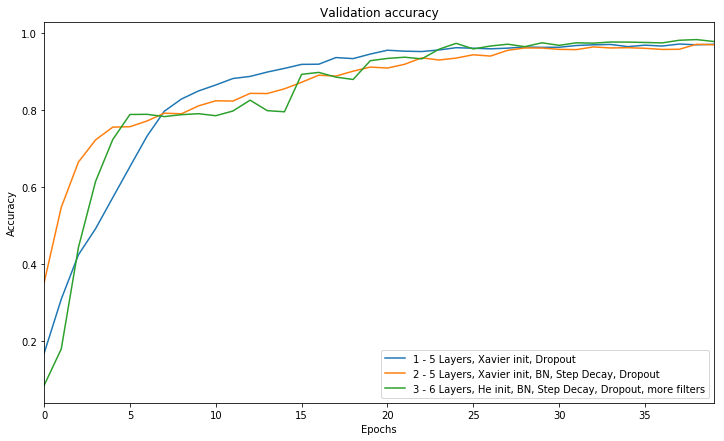

In [14]:
# Plot training process of three different CNN architectures
plot_f1 = pd.read_csv('fnet_5layers.csv')
plot_f1.rename(columns={'accuracy':'1 - 5 Layers, Xavier init, Dropout'}, inplace=True)
plot_f2 = pd.read_csv('fnet_5layers_batch_decay.csv')
plot_f2.rename(columns={'accuracy':'2 - 5 Layers, Xavier init, BN, Step Decay, Dropout'}, inplace=True)
plot_f3 = pd.read_csv('fnet_6layers_bn_decay_moreparameters.csv')
plot_f3.rename(columns={'accuracy':'3 - 6 Layers, He init, BN, Step Decay, Dropout, more filters'},
               inplace=True)

ax = plot_f1.plot(title='Validation accuracy', figsize=(12, 7))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plot_f2.plot(ax=ax)
plot_f3.plot(ax=ax)

---

## Step 3: Test a Model on New Images

To give more insight into how our model is working, let's download ten pictures of German traffic signs from the internet and use our model to predict the traffic sign types.

### Load and Output the Images

Image: 1 Shape: (32, 32, 3)
Image: 2 Shape: (32, 32, 3)
Image: 3 Shape: (32, 32, 3)
Image: 4 Shape: (32, 32, 3)
Image: 5 Shape: (32, 32, 3)
Image: 6 Shape: (32, 32, 3)
Image: 7 Shape: (32, 32, 3)
Image: 8 Shape: (32, 32, 3)
Image: 9 Shape: (32, 32, 3)
Image: 10 Shape: (32, 32, 3)


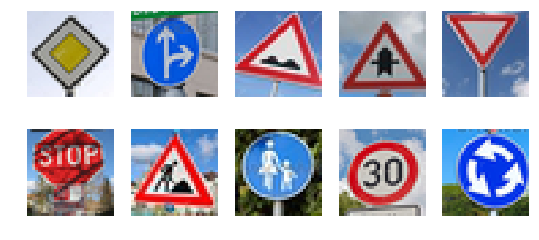

In [15]:
# Load the images and plot them
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import glob

images = []
for img in glob.glob('./test_imgs/*.jpg'):
    image = mpimg.imread(img)
    images.append(image)

plt.figure(figsize=(9, 4))
for i, image in enumerate(images):
    print("Image: {} Shape: {}".format(i+1, image.shape))
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

11


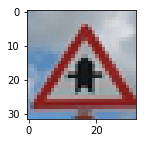

In [16]:
# Create new test and label set
X_test_new = images
# set labels according to signnames.csv
y_test_new = [12, 36, 22, 11, 13, 14, 25, 27, 1, 40]

plt.figure(figsize=(2,2))
plt.imshow(X_test_new[3])
print(y_test_new[3])

In [17]:
# Preprocess test data
import numpy as np

X_test_new_norm = (X_test_new - np.mean(X_test_new)) / np.std(X_test_new, axis=0)

### Predict the Sign Type for Each Image

In [18]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./fnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    predicted_labels = tf.argmax(logits, 1)
    prediction = sess.run(predicted_labels, feed_dict={x: X_test_new_norm,
                                                 keep_prob_conv1: 1.0,
                                                 keep_prob_conv2: 1.0,
                                                 keep_prob_fc: 1.0,
                                                 phase: False})

actual = [sign_names['SignName'].tolist()[i] for i in y_test_new]
predictions = [sign_names['SignName'].tolist()[i] for i in prediction]
print()
for i in range(len(y_test_new)):
    print("Sign {}-'{}' predicted as '{}'".format(i+1, actual[i], predictions[i]))

INFO:tensorflow:Restoring parameters from ./fnet

Sign 1-'Priority road' predicted as 'Priority road'
Sign 2-'Go straight or right' predicted as 'Go straight or right'
Sign 3-'Bumpy road' predicted as 'Bumpy road'
Sign 4-'Right-of-way at the next intersection' predicted as 'Right-of-way at the next intersection'
Sign 5-'Yield' predicted as 'Ahead only'
Sign 6-'Stop' predicted as 'Stop'
Sign 7-'Road work' predicted as 'Road work'
Sign 8-'Pedestrians' predicted as 'Turn left ahead'
Sign 9-'Speed limit (30km/h)' predicted as 'Speed limit (30km/h)'
Sign 10-'Roundabout mandatory' predicted as 'Roundabout mandatory'


### Analyze Performance

In [19]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./fnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    accuracy = evaluate(X_test_new_norm, y_test_new)
    print("Test accuracy = {:.3f}".format(accuracy))

INFO:tensorflow:Restoring parameters from ./fnet
Test accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, let's print out the model's softmax probabilities to show the **certainty** of the model's predictions.

In [20]:
# Print out the top five softmax probabilities 
# for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./fnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    
    k = 5
    softmax_pred = tf.nn.softmax(logits)
    top_five_pred = tf.nn.top_k(softmax_pred, k=k)
    
    top_five = sess.run(top_five_pred, feed_dict={x: X_test_new_norm,
                                                 keep_prob_conv1: 1.0,
                                                 keep_prob_conv2: 1.0,
                                                 keep_prob_fc: 1.0,
                                                 phase: False})

INFO:tensorflow:Restoring parameters from ./fnet


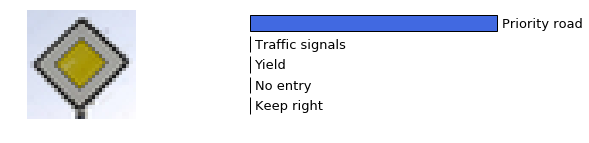

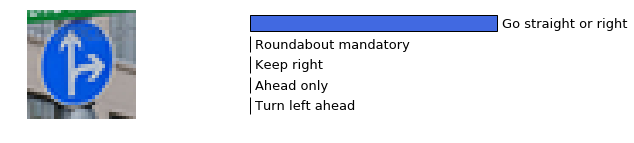

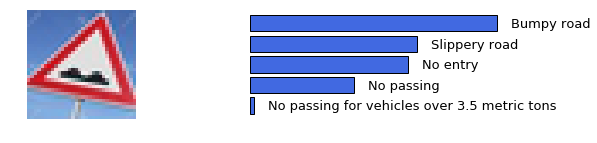

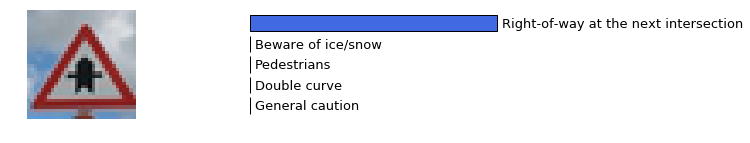

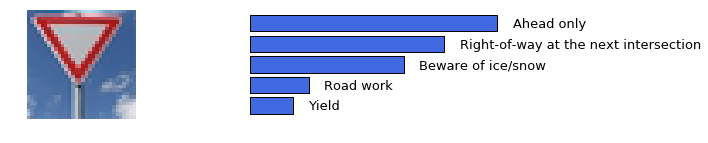

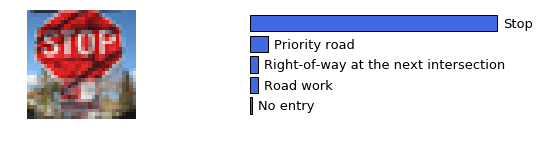

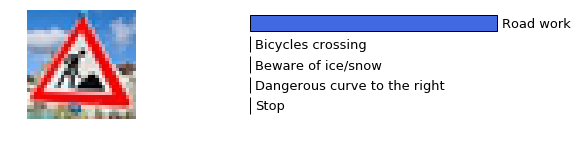

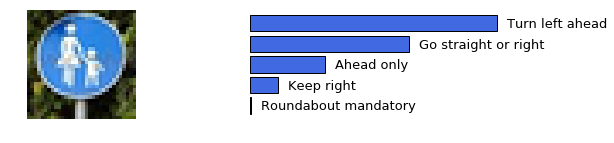

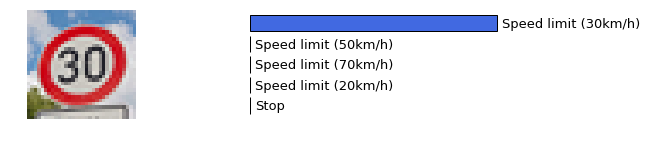

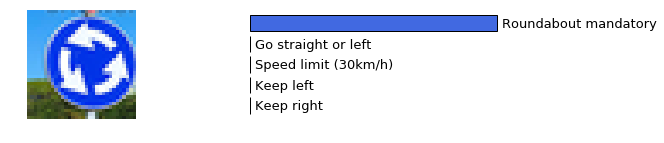

In [21]:
# Visualize top 5 probabilities
input_signs = [sign_names['SignName'].tolist()[i] for i in y_test_new]
predictions = [[sign_names['SignName'].tolist()[i] for i in group] for group in top_five[1].tolist()]
probabilities = top_five[0].tolist()

nrows = 1
ncols = 2
for i in range(len(images)):
    gs = gridspec.GridSpec(nrows, ncols, wspace=0.15, hspace=0.1)
    fig = plt.figure(figsize=(10,2))
    ax1, ax2 = [plt.subplot(gs[:, i]) for i in range(ncols)]
    
    ax1 = plt.subplot(gs[0])
    ax1.imshow(images[i])
    ax1.axis('off')
    
    ax2.barh(np.arange(len(probabilities[i])), probabilities[i],
             align='center', color='royalblue', edgecolor='black', linewidth=1)
    ax2.get_yaxis().set_ticks([i for i in range(len(probabilities[i]))])
    ax2.invert_yaxis()
    for j in range(len(probabilities[i])):
        ax2.text(probabilities[i][j]+0.02, j+0.2, predictions[i][j], fontsize=13)
    ax2.axis('off')

plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training our neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

In [22]:
# Visualize network's feature maps
import random

def outputFeatureMap(image_input, tf_activation, layer, activation_min=-1, activation_max=-1 ,plt_num=1):
    '''
    image_input: the test image being fed into the network to produce the feature maps.
    tf_activation: should be a tf variable name used during our training procedure that represents the calculated
    state of a specific weight layer.
    activation_min/max: can be used to view the activation contrast in more detail, by default matplot 
    sets min and max to the actual min and max values of the output.
    plt_num: used to plot out multiple different weight feature map sets on the same block, just extend 
    the plt number for each new feature map entry.

    Here make sure to preprocess image_input in a way our network expects with size, normalization, etc if needed

    Note: x should be the same name as our network's tensorflow data placeholder variable
    '''
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, 
                                                            keep_prob_conv1: 1.0,
                                                            keep_prob_conv2: 1.0,
                                                            keep_prob_fc: 1.0,
                                                            phase: False})
    featuremaps = activation.shape[-1]
    num_of_featuremaps = 50 if featuremaps > 50 else featuremaps
    
    plt.figure(plt_num, figsize=(15,8))
    plt.suptitle(layer, size=15)
    
    for featuremap in range(num_of_featuremaps):
        # sets the number of feature maps to show on each row and column
        # 50 first feature maps of tf_activation
        plt.subplot(5, 10, featuremap+1)
        plt.title('FeatureMap ' + str(featuremap), fontsize=10)
        
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation='nearest', 
                       vmin =activation_min, vmax=activation_max, cmap='gray')
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation='nearest', 
                       vmax=activation_max, cmap='gray')
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation='nearest', 
                       vmin=activation_min, cmap='gray')
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation='nearest', cmap='gray')
        plt.axis('off')

In [23]:
# Preprocess image
image_input = X_test_new_norm[6]
image_input = np.reshape(image_input, (1, ) + image_input.shape)
print(image_input.shape)

(1, 32, 32, 3)


INFO:tensorflow:Restoring parameters from ./fnet


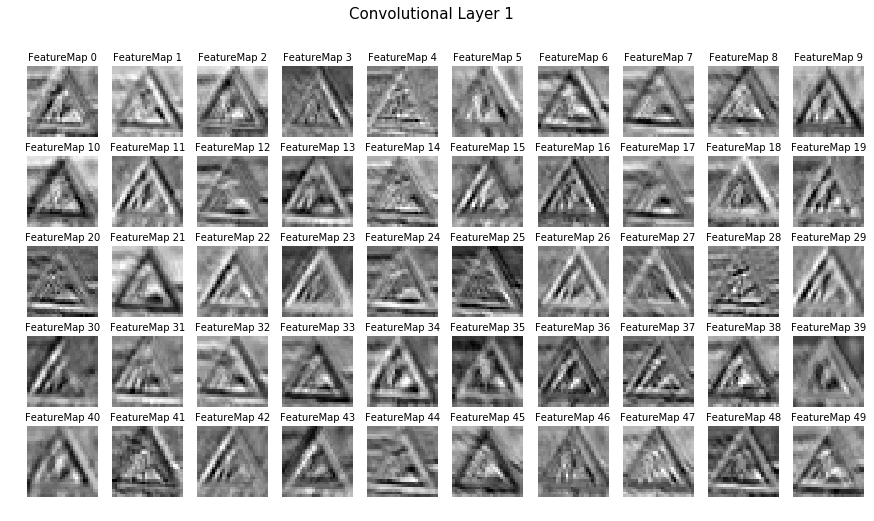

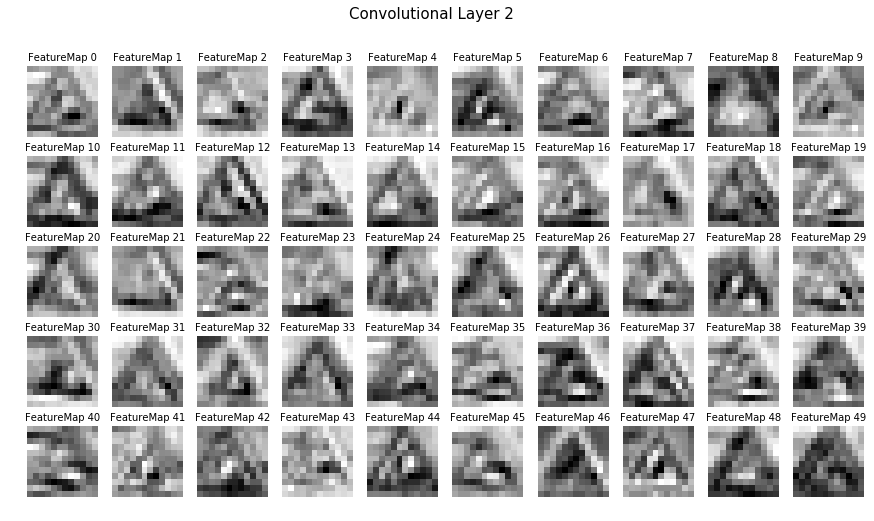

In [24]:
# Plot some of feature maps
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./fnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    conv1 = graph.get_tensor_by_name('conv1:0')
    conv2 = graph.get_tensor_by_name('conv2:0')
    
    outputFeatureMap(image_input, conv1, 'Convolutional Layer 1', plt_num=1)
    outputFeatureMap(image_input, conv2, 'Convolutional Layer 2', plt_num=2)